# Import Libraries

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import (f1_score, confusion_matrix, accuracy_score, 
precision_score, recall_score, classification_report)
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.manifold import TSNE
from sklearn.tree import plot_tree
import numpy as np
import pickle

# Obtain Data

Read csv file with player info into players_df, reformat 'Team' column and create 'Name-Team' column

In [57]:
players_df = pd.read_csv('Data/players.csv')
players_df['Team'] = players_df['Team'].apply(lambda x: x.replace('-', ' ').title())
players_df['Name-Team'] = players_df['Name'] + ' / ' + players_df['Team']
print(players_df.shape)
players_df.head()

(4755, 4)


,Name,Position,Team,Name-Team
0,Corey Davis Jr.,G,Houston,Corey Davis Jr. / Houston
1,Armoni Brooks,G,Houston,Armoni Brooks / Houston
2,Galen Robinson Jr.,G,Houston,Galen Robinson Jr. / Houston
3,Nate Hinton,G,Houston,Nate Hinton / Houston
4,Dejon Jarreau,G,Houston,Dejon Jarreau / Houston


Read csv files with player stats into stats_df, reformat 'Team' column and create 'Name-Team' column

In [58]:
stats_df = pd.read_csv('Data/stats.csv')
stats_df['Team'] = stats_df['Team'].apply(lambda x: x.replace('-', ' ').title())
stats_df['Name-Team'] = stats_df['Name'] + ' / ' + stats_df['Team']
stats_df.drop(columns=['Name','Team'], inplace=True)
print(stats_df.shape)
stats_df.head()

(4754, 25)


,G,GS,MP,FG,FGA,FG%,2P,2PA,2P%,3P,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Name-Team
0,37,36,33.0,5.5,13.0,0.420,2.5,5.0,0.492,3.0,...,0.7,2.6,3.3,2.8,1.0,0.1,1.5,1.8,17.0,Corey Davis Jr. / Houston
1,37,36,30.7,4.6,11.5,0.405,1.4,3.1,0.443,3.3,...,1.1,5.2,6.3,0.9,0.8,0.3,0.9,1.6,13.4,Armoni Brooks / Houston
2,30,0,18.0,3.0,6.4,0.471,2.6,5.3,0.494,0.4,...,0.3,3.4,3.8,3.3,0.6,0.5,2.1,2.3,8.7,Dejon Jarreau / Houston
3,37,37,29.9,2.8,6.3,0.449,2.1,4.2,0.500,0.8,...,0.5,2.6,3.1,4.9,1.3,0.1,1.7,1.4,8.0,Galen Robinson Jr. / Houston
4,37,1,19.2,2.4,5.9,0.413,1.7,3.6,0.459,0.8,...,1.1,3.3,4.4,1.2,1.0,0.1,0.9,1.5,7.2,Nate Hinton / Houston


Merge tables with player data and player stats together into df

In [59]:
df = pd.merge(players_df, stats_df, how='inner', on='Name-Team')
print(df.shape)
df.head()

(4753, 28)


,Name,Position,Team,Name-Team,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Corey Davis Jr.,G,Houston,Corey Davis Jr. / Houston,37,36,33.0,5.5,13.0,0.420,...,0.869,0.7,2.6,3.3,2.8,1.0,0.1,1.5,1.8,17.0
1,Armoni Brooks,G,Houston,Armoni Brooks / Houston,37,36,30.7,4.6,11.5,0.405,...,0.630,1.1,5.2,6.3,0.9,0.8,0.3,0.9,1.6,13.4
2,Galen Robinson Jr.,G,Houston,Galen Robinson Jr. / Houston,37,37,29.9,2.8,6.3,0.449,...,0.667,0.5,2.6,3.1,4.9,1.3,0.1,1.7,1.4,8.0
3,Nate Hinton,G,Houston,Nate Hinton / Houston,37,1,19.2,2.4,5.9,0.413,...,0.857,1.1,3.3,4.4,1.2,1.0,0.1,0.9,1.5,7.2
4,Dejon Jarreau,G,Houston,Dejon Jarreau / Houston,30,0,18.0,3.0,6.4,0.471,...,0.694,0.3,3.4,3.8,3.3,0.6,0.5,2.1,2.3,8.7


# Scrub Data

Create df.info() overview of df to determine what scrubbing needed

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4753 entries, 0 to 4752
Data columns (total 28 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       4753 non-null   object 
 1   Position   4751 non-null   object 
 2   Team       4753 non-null   object 
 3   Name-Team  4753 non-null   object 
 4   G          4753 non-null   int64  
 5   GS         4753 non-null   int64  
 6   MP         4753 non-null   float64
 7   FG         4753 non-null   float64
 8   FGA        4753 non-null   float64
 9   FG%        4617 non-null   float64
 10  2P         4753 non-null   float64
 11  2PA        4753 non-null   float64
 12  2P%        4502 non-null   float64
 13  3P         4753 non-null   float64
 14  3PA        4753 non-null   float64
 15  3P%        4002 non-null   float64
 16  FT         4753 non-null   float64
 17  FTA        4753 non-null   float64
 18  FT%        4262 non-null   float64
 19  ORB        4753 non-null   float64
 20  DRB     

Drop descriptive features not useful for modeling position or eda

In [61]:
df.drop(columns = ['Name', 'Team'], inplace=True)

Replace missing position values with results from looking these up in alternative sources

In [62]:
df.loc[[2830, 3597],'Position']='G'
df[df['Position'].isnull()]

,Position,Name-Team,G,GS,MP,FG,FGA,FG%,2P,2PA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS


Replace missing 'FG%' values with 0 to represent that these players had not attempted any field goals

In [63]:
df['FG%'] = df['FG%'].fillna(value=0)
df[df['FG%'].isnull()]

,Position,Name-Team,G,GS,MP,FG,FGA,FG%,2P,2PA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS


Replace missing '2P%' values with 0 to represent that these players had not attempted any 2P field goals

In [64]:
df['2P%'] = df['2P%'].fillna(value=0)
df[df['2P%'].isnull()]

,Position,Name-Team,G,GS,MP,FG,FGA,FG%,2P,2PA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS


Replace missing '3P%' values with 0 to represent that these players had not attempted any 3P field goals

In [65]:
df['3P%'] = df['3P%'].fillna(value=0)
df[df['3P%'].isnull()]

,Position,Name-Team,G,GS,MP,FG,FGA,FG%,2P,2PA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS


Replace missing 'FT%' values with 0 to represent that these players had not attempted any FTs

In [66]:
df['FT%'] = df['FT%'].fillna(value=0)
df[df['FT%'].isnull()]

,Position,Name-Team,G,GS,MP,FG,FGA,FG%,2P,2PA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS


Plot raw positional class balance to determine what scrubbing needed

G    2767
F    1750
C     235
D       1
Name: Position, dtype: int64

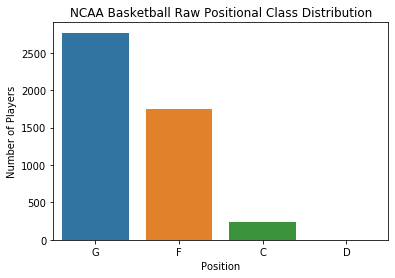

In [67]:
fig, ax = plt.subplots()
sns.countplot(x='Position', data=df, ax=ax)
ax.set_title('NCAA Basketball Raw Positional Class Distribution')
ax.set_ylabel('Number of Players')
df['Position'].value_counts()

Merge 'F' class with the overlapping 'C' class, as well as one mislabeled 'D' class datapoint and update Positional string values to dummy values

In [68]:
position_dict = {'G': 0, 'F': 1, 'C': 1, 'D': 1}
df['Position'] = df['Position'].replace(position_dict)
df['Position'].value_counts()


0    2767
1    1986
Name: Position, dtype: int64

Final df.info() overview of df after scrubbing

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4753 entries, 0 to 4752
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Position   4753 non-null   int64  
 1   Name-Team  4753 non-null   object 
 2   G          4753 non-null   int64  
 3   GS         4753 non-null   int64  
 4   MP         4753 non-null   float64
 5   FG         4753 non-null   float64
 6   FGA        4753 non-null   float64
 7   FG%        4753 non-null   float64
 8   2P         4753 non-null   float64
 9   2PA        4753 non-null   float64
 10  2P%        4753 non-null   float64
 11  3P         4753 non-null   float64
 12  3PA        4753 non-null   float64
 13  3P%        4753 non-null   float64
 14  FT         4753 non-null   float64
 15  FTA        4753 non-null   float64
 16  FT%        4753 non-null   float64
 17  ORB        4753 non-null   float64
 18  DRB        4753 non-null   float64
 19  TRB        4753 non-null   float64
 20  AST     

Save scrubbed data to df

In [70]:
df.to_csv('Data/ncaa_dataset.csv', index=False)

Drop Name-Team column

In [71]:
df.drop(columns = ['Name-Team'], inplace=True)

# Explore data

Calculate class weights

In [72]:
print(df['Position'].value_counts())
df['Position'].value_counts()/df['Position'].count()

0    2767
1    1986
Name: Position, dtype: int64


0    0.582159
1    0.417841
Name: Position, dtype: float64

Plot class balance

Text(0, 0.5, 'Count')

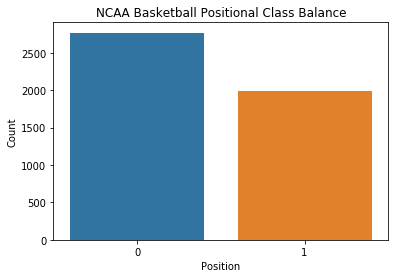

In [73]:
fig, ax = plt.subplots()
sns.countplot(x='Position',data=df, ax=ax)
ax.set_title('NCAA Basketball Positional Class Balance')
ax.set_ylabel('Count')

Plot distributions of model features

/Users/blantj/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


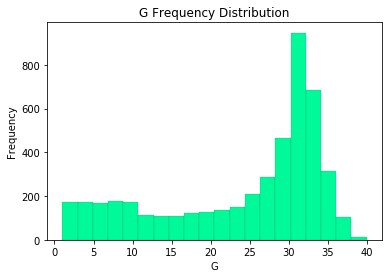

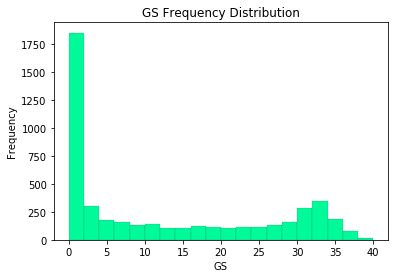

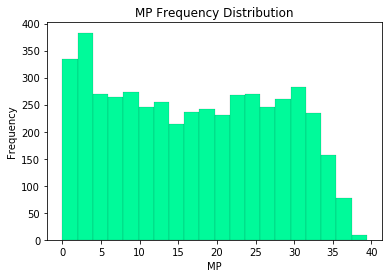

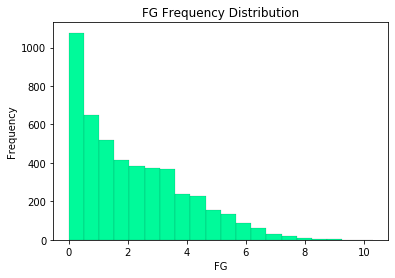

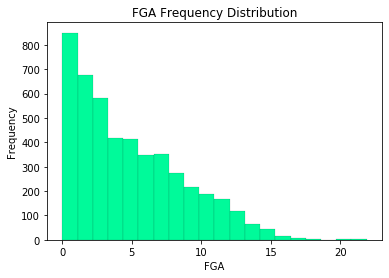

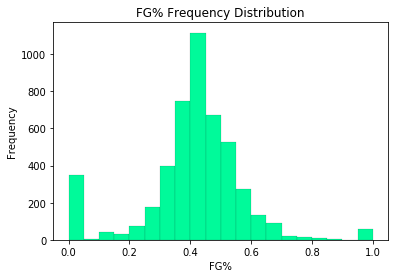

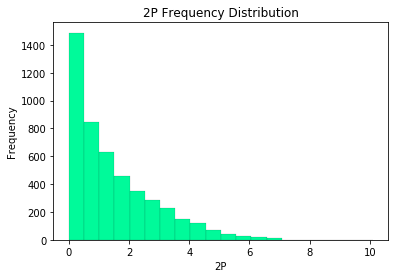

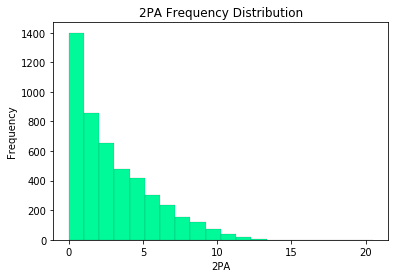

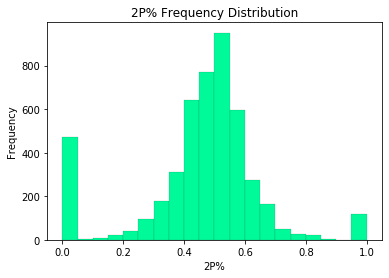

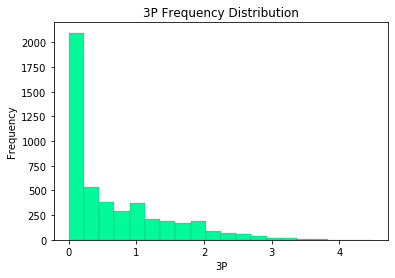

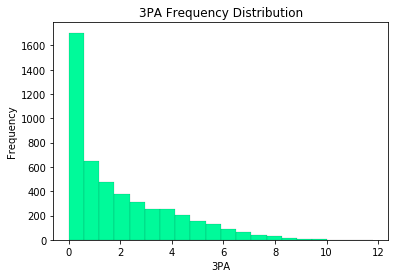

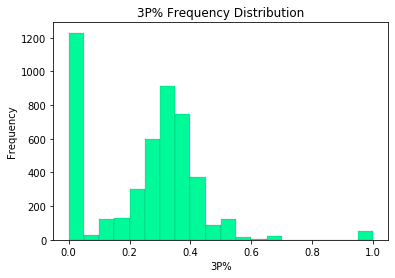

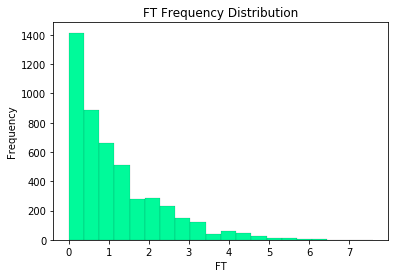

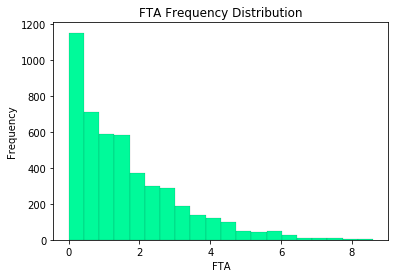

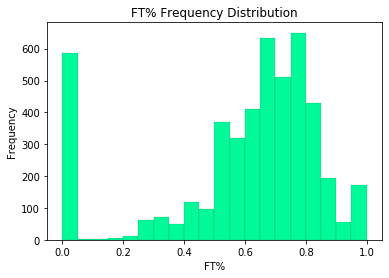

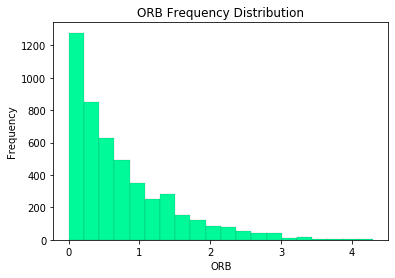

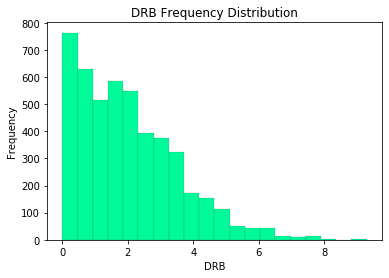

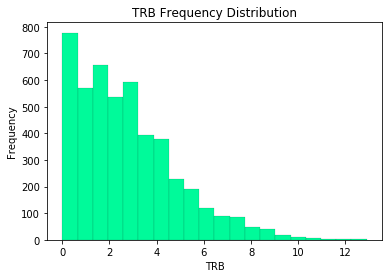

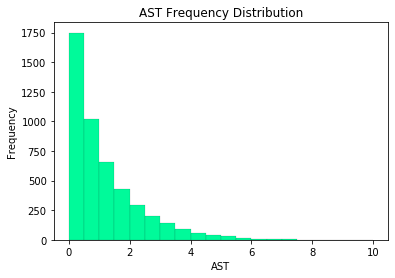

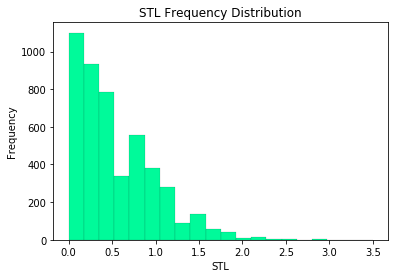

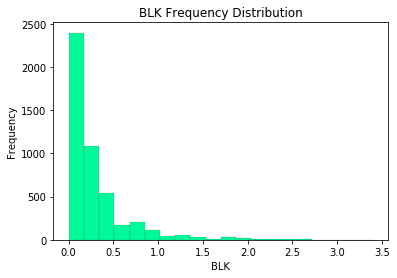

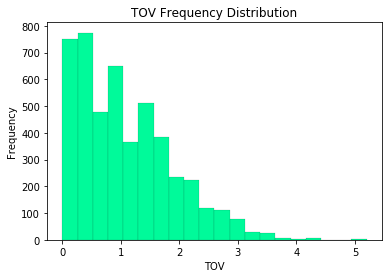

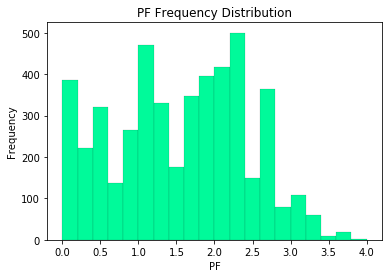

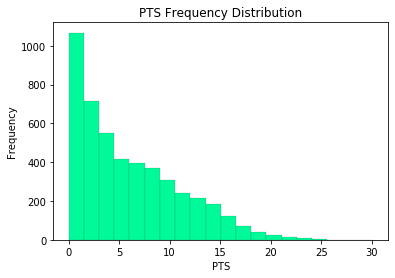

In [74]:
for feature in df.columns[1:]:
    fig, ax = plt.subplots()
    sns.distplot(df[feature], kde=False, bins=20, color='mediumspringgreen', 
                 hist_kws=dict(alpha=1, edgecolor="k", linewidth=.1), ax=ax)
    ax.set_title(f'{feature} Frequency Distribution')
    ax.set_ylabel('Frequency')

Plot frequency distribution of games played per player

Text(0.5, 1.0, 'Frequency Distribution of Games Played for NCAAB Players')

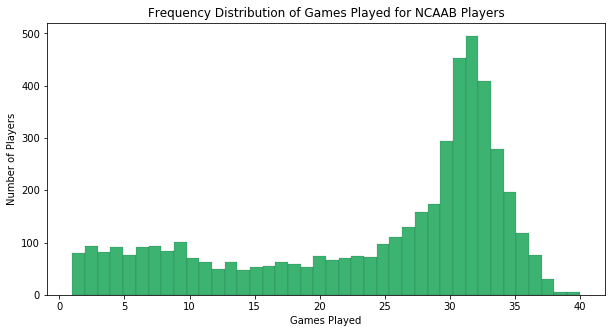

In [75]:
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(df['G'], kde=False, bins=40, color='mediumseagreen', ax=ax, 
             hist_kws=dict(alpha=1, edgecolor="k", linewidth=.1))
ax.set_xlabel('Games Played')
ax.set_ylabel('Number of Players')
ax.set_title('Frequency Distribution of Games Played for NCAAB Players')

Plot frequency distribution of minutes played per player

Text(0.5, 1.0, 'Frequency Distribution of Minutes Played for NCAAB Players')

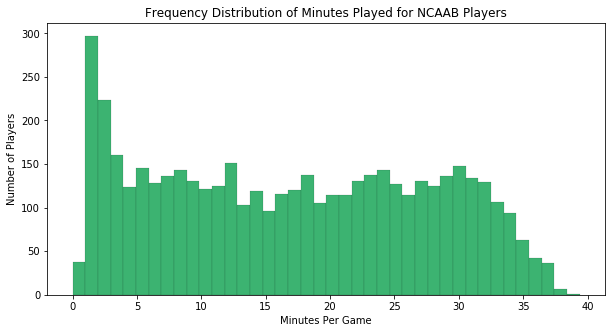

In [76]:
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(df['MP'], kde=False, bins=40, color='mediumseagreen', ax=ax, 
             hist_kws=dict(alpha=1, edgecolor="k", linewidth=.1))
ax.set_xlabel('Minutes Per Game')
ax.set_ylabel('Number of Players')
ax.set_title('Frequency Distribution of Minutes Played for NCAAB Players')

# Modeling

Create x and y variables from df

In [77]:
x_cols = df.columns[4:]
x = df[x_cols]
y = df['Position']

Perform train test split on data

In [78]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state = 51)

Apply standard scaler to x variables

In [79]:
ss = StandardScaler()
ss.fit(x_train)
x_train = ss.transform(x_train)
x_test = ss.transform(x_test)
x_train = pd.DataFrame(x_train, columns = x.columns)
x_test = pd.DataFrame(x_test, columns = x.columns)
x_train.head()

,FG,FGA,FG%,2P,2PA,2P%,3P,3PA,3P%,FT,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,2.172943,2.101547,0.306723,1.733189,1.699516,0.339302,1.929347,1.844345,0.682296,2.461522,...,0.887549,-0.611789,0.405781,0.091671,1.416228,0.998408,0.305260,1.621381,0.543714,2.336273
1,-0.965148,-1.015503,-0.048759,-0.846438,-1.011382,2.717285,-0.717944,-0.643398,-0.587888,-0.901545,...,-0.336895,-1.043332,-1.109915,-1.156687,-0.679136,-0.927166,-0.721365,-1.297124,-1.391760,-1.001585
2,-1.189297,-1.041264,-2.458805,-1.061406,-0.935019,-2.257575,-0.850308,-0.792662,-1.370804,-0.990047,...,-2.186510,-0.611789,-0.648616,-0.676550,-0.679136,-1.141118,-0.721365,-0.932311,-1.733315,-1.178295
3,2.621241,2.178829,0.601954,3.166314,2.883148,0.538296,0.340973,0.451209,0.304525,3.789049,...,0.469536,0.395147,1.723778,1.388042,3.427779,3.993745,0.561916,3.080634,0.885268,2.709328
4,3.854063,2.153069,1.638274,4.814409,3.074056,1.458645,0.076244,0.152680,0.479723,2.461522,...,0.180997,3.991344,2.250977,2.972496,0.829526,3.351887,3.898447,1.621381,0.657565,3.259093


Pickle standard scaler

In [83]:
ss_file = open('Pickles/standard_scaler.pickle', 'wb')
pickle.dump(ss, ss_file)
ss_file.close()

Build and evaluate baseline model

In [26]:
dc = DummyClassifier(strategy='stratified', random_state=47)
dc.fit(x_train, y_train)
y_test_pred_dc = dc.predict(x_test)
y_train_pred_dc = dc.predict(x_train)
print('Train f1 score', f1_score(y_train, y_train_pred_dc))
print('Test f1 score', f1_score(y_test, y_test_pred_dc))

Train f1 score 0.42946317103620474
Test f1 score 0.4455205811138015


Create Baseline Model confusion matrix

[Text(0, 0.5, 'Guard'), Text(0, 1.5, 'Forward')]

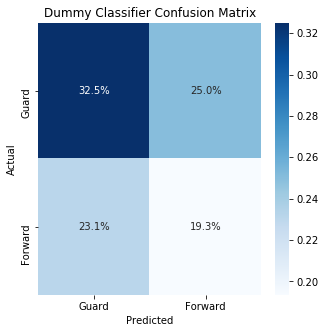

In [27]:
dc_cm = confusion_matrix(y_test, y_test_pred_dc)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(dc_cm/np.sum(dc_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Dummy Classifier Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Guard','Forward'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Guard','Forward'])

Gridsearch KNN Model params

In [25]:
knn_param_grid = {'n_neighbors': range(1,51), 'weights':['uniform', 'distance']}
knn_gs_model = KNeighborsClassifier()
knn_gs = GridSearchCV(knn_gs_model, knn_param_grid, scoring='f1', n_jobs=-1, cv=10, verbose=1)
knn_gs.fit(x_train, y_train)
print('Best params:', knn_gs.best_params_)
print('Best estimator:', knn_gs.best_estimator_)
print('Best score: ', knn_gs.best_score_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   50.0s


Best params: {'n_neighbors': 24, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=24, p=2,
                     weights='distance')
Best score:  0.7870462934466833


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.0min finished


Build and evaluate KNN Model

In [26]:
knn =  KNeighborsClassifier(n_neighbors=24)
knn.fit(x_train, y_train)
y_train_pred_knn = knn.predict(x_train)
y_test_pred_knn = knn.predict(x_test)
print('Train f1 Score', f1_score(y_train, y_train_pred_knn, ))
print('Test f1 Score', f1_score(y_test, y_test_pred_knn))

Train f1 Score 0.8015032456440041
Test f1 Score 0.7856191744340879


Create KNN confusion matrix

[Text(0, 0.5, 'Guard'), Text(0, 1.5, 'Forward')]

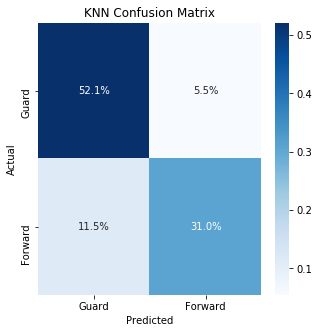

In [27]:
knn_cm = confusion_matrix(y_test, y_test_pred_knn)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(knn_cm/np.sum(knn_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('KNN Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Guard','Forward'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Guard','Forward'])

Gridsearch Random Forest params

In [157]:
rf_param_grid = {'max_depth':range(25,41), 'min_samples_split': range(1,11)}
rf_gs_model = RandomForestClassifier()
rf_gs = GridSearchCV(rf_gs_model, rf_param_grid, scoring='f1', n_jobs=-1, cv=5, verbose=1)
rf_gs.fit(x_train, y_train)
print('Best params:', rf_gs.best_params_)
print('Best estimator:', rf_gs.best_estimator_)
print('Best score: ', rf_gs.best_score_)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 10.7min finished


Best params: {'max_depth': 32, 'min_samples_split': 3}
Best estimator: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=32, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Best score:  0.8176847723782915


Build and evaluate Random Forest model

In [47]:
rf =  RandomForestClassifier(max_depth=32, min_samples_split=3)
rf.fit(x_train, y_train)
y_train_pred_rf = rf.predict(x_train)
y_test_pred_rf = rf.predict(x_test)
print('Train f1 Score', f1_score(y_train, y_train_pred_rf))
print('Test f1 Score', f1_score(y_test, y_test_pred_rf))

Train f1 Score 0.9923664122137404
Test f1 Score 0.815958815958816


Create Random Forest confusion matrix

[Text(0, 0.5, 'Guard'), Text(0, 1.5, 'Forward')]

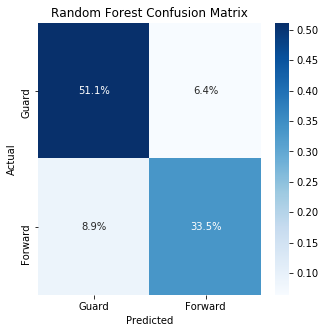

In [26]:
rf_cm = confusion_matrix(y_test, y_test_pred_rf)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(rf_cm/np.sum(rf_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Random Forest Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Guard','Forward'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Guard','Forward'])

Gridsearch Adaboost params

In [36]:
ab_param_grid = {'learning_rate': [x/100 for x in range(90,110)], 'n_estimators': [100, 200, 300]}
ab_gs_model = AdaBoostClassifier()
ab_gs = GridSearchCV(ab_gs_model, ab_param_grid, scoring='f1', n_jobs=-1, cv=5, verbose=1)
ab_gs.fit(x_train, y_train)
print('Best params:', ab_gs.best_params_)
print('Best estimator:', ab_gs.best_estimator_)
print('Best score: ', ab_gs.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.7min finished


Best params: {'learning_rate': 0.93, 'n_estimators': 100}
Best estimator: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.93,
                   n_estimators=100, random_state=None)
Best score:  0.815038771000755


Build and evaluate Adaboost model

In [27]:
ab =  AdaBoostClassifier(learning_rate = .93, n_estimators=100)
ab.fit(x_train, y_train)
y_train_pred_ab = ab.predict(x_train)
y_test_pred_ab = ab.predict(x_test)
print('Train f1 Score', f1_score(y_train, y_train_pred_ab))
print('Test f1 Score', f1_score(y_test, y_test_pred_ab))

Train f1 Score 0.8345418589321029
Test f1 Score 0.8229299363057324


Create Adaboost confusion matrix

[Text(0, 0.5, 'Guard'), Text(0, 1.5, 'Forward')]

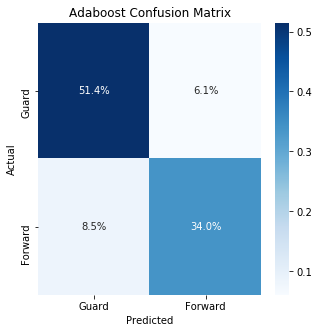

In [28]:
ab_cm = confusion_matrix(y_test, y_test_pred_ab)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(ab_cm/np.sum(ab_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Adaboost Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Guard','Forward'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Guard','Forward'])

Gridsearch XG Boost model params

In [42]:
xgb_param_grid = {'max_depth': range(1, 6), 'gamma': [.0000001, .000001, .00001],
                 'min_split_loss': [.01, .1, 1]}
xgb_gs_model = XGBClassifier(lr=.01, booster='gbtree')
xgb_gs = GridSearchCV(xgb_gs_model, xgb_param_grid, scoring='f1', n_jobs=-1, cv=5, verbose=1)
xgb_gs.fit(x_train, y_train)
print('Best params:', xgb_gs.best_params_)
print('Best estimator:', xgb_gs.best_estimator_)
print('Best score: ', xgb_gs.best_score_)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:   41.7s finished


[02:43:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { lr } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best params: {'gamma': 1e-07, 'max_depth': 2, 'min_split_loss': 0.1}
Best estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1e-07, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, lr=0.01, max_delta_step=0, max_depth=2,
              min_child_weight=1, min_split_loss=0.1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_we

Build and evaluate XGBoost Model

In [47]:
xgb = XGBClassifier(max_depth=2, min_split_loss = .1)
xgb.fit(x_train, y_train)
y_train_pred_xgb = xgb.predict(x_train)
y_test_pred_xgb = xgb.predict(x_test)
print('Train F1 Score: ', f1_score(y_train, y_train_pred_xgb))
print('Test F1 Score: ', f1_score(y_test, y_test_pred_xgb))

Train F1 Score:  0.8704730831973899
Test F1 Score:  0.824583866837388


Create XGBoost confusion matrix

[Text(0, 0.5, 'Guard'), Text(0, 1.5, 'Forward')]

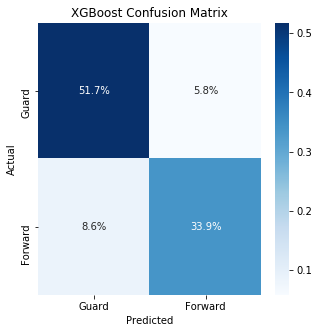

In [44]:
xgb_cm = confusion_matrix(y_test, y_test_pred_xgb)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(xgb_cm/np.sum(xgb_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('XGBoost Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Guard','Forward'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Guard','Forward'])

Gridsearch SVM model params

In [42]:
svm_param_grid = {'C': [x/10 for x in range(0,51)]}
svm_gs_model = SVC()
svm_gs = GridSearchCV(svm_gs_model, svm_param_grid, scoring='f1', n_jobs=-1, cv=5, verbose=1)
svm_gs.fit(x_train, y_train)
print('Best params:', svm_gs.best_params_)
print('Best estimator:', svm_gs.best_estimator_)
print('Best score: ', svm_gs.best_score_)

Fitting 5 folds for each of 51 candidates, totalling 255 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 255 out of 255 | elapsed:  1.8min finished


Best params: {'C': 3.4}
Best estimator: SVC(C=3.4, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Best score:  0.8206268652999865


Build and evaluate SVM model

In [30]:
svm = SVC(C=3.4)
svm.fit(x_train, y_train)
y_train_pred_svm = svm.predict(x_train)
y_test_pred_svm = svm.predict(x_test)
print('Train F1 Score: ', f1_score(y_train, y_train_pred_svm))
print('Test F1 Score: ', f1_score(y_test, y_test_pred_svm))

Train F1 Score:  0.8480000000000001
Test F1 Score:  0.8253557567917207


Pickle SVM model

In [82]:
svm_file = open('Pickles/svm.pickle', 'wb')
pickle.dump(svm, svm_file)
svm_file.close()

Create SVM confusion matrix

[Text(0, 0.5, 'Guard'), Text(0, 1.5, 'Forward')]

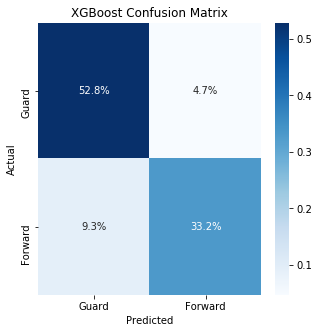

In [28]:
svm_cm = confusion_matrix(y_test, y_test_pred_svm)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(svm_cm/np.sum(svm_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('XGBoost Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Guard','Forward'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Guard','Forward'])

Build and evaluate Voting Classifier

In [34]:
knn_vc =  KNeighborsClassifier(n_neighbors=24)
rf_vc = RandomForestClassifier(max_depth=32, min_samples_split=3)
ab_vc = AdaBoostClassifier(learning_rate = .93, n_estimators=100)
xgb_vc = XGBClassifier(max_depth=2, min_split_loss = .1)
svm_vc = SVC(C=1.3, probability=True)
vc= VotingClassifier([('xgb', xgb_vc), ('knn', knn_vc), ('ab', ab_vc)], voting='soft', 
                     weights = [.5, .69, .5])
vc.fit(x_train, y_train)
y_train_pred_vc = vc.predict(x_train)
y_test_pred_vc = vc.predict(x_test)
print('Train f1 Score', f1_score(y_train, y_train_pred_vc))
print('Test f1 Score', f1_score(y_test, y_test_pred_vc))

Train f1 Score 0.8458709461718488
Test f1 Score 0.8292046936114732


Create Voting Classifier confusion matrix

[Text(0, 0.5, 'Guard'), Text(0, 1.5, 'Forward')]

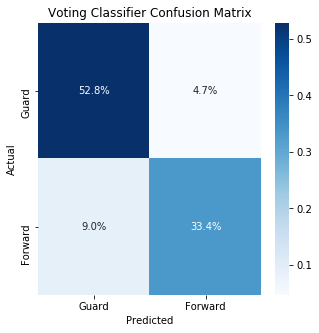

In [35]:
xgb_vc = confusion_matrix(y_test, y_test_pred_vc)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(xgb_vc/np.sum(xgb_vc), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Voting Classifier Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Guard','Forward'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Guard','Forward'])

# Analyze Data

Plot Random Forest Sample Decision Tree

Text(0.5, 1.0, 'NCAA Basketball Position Classification Decision Tree')

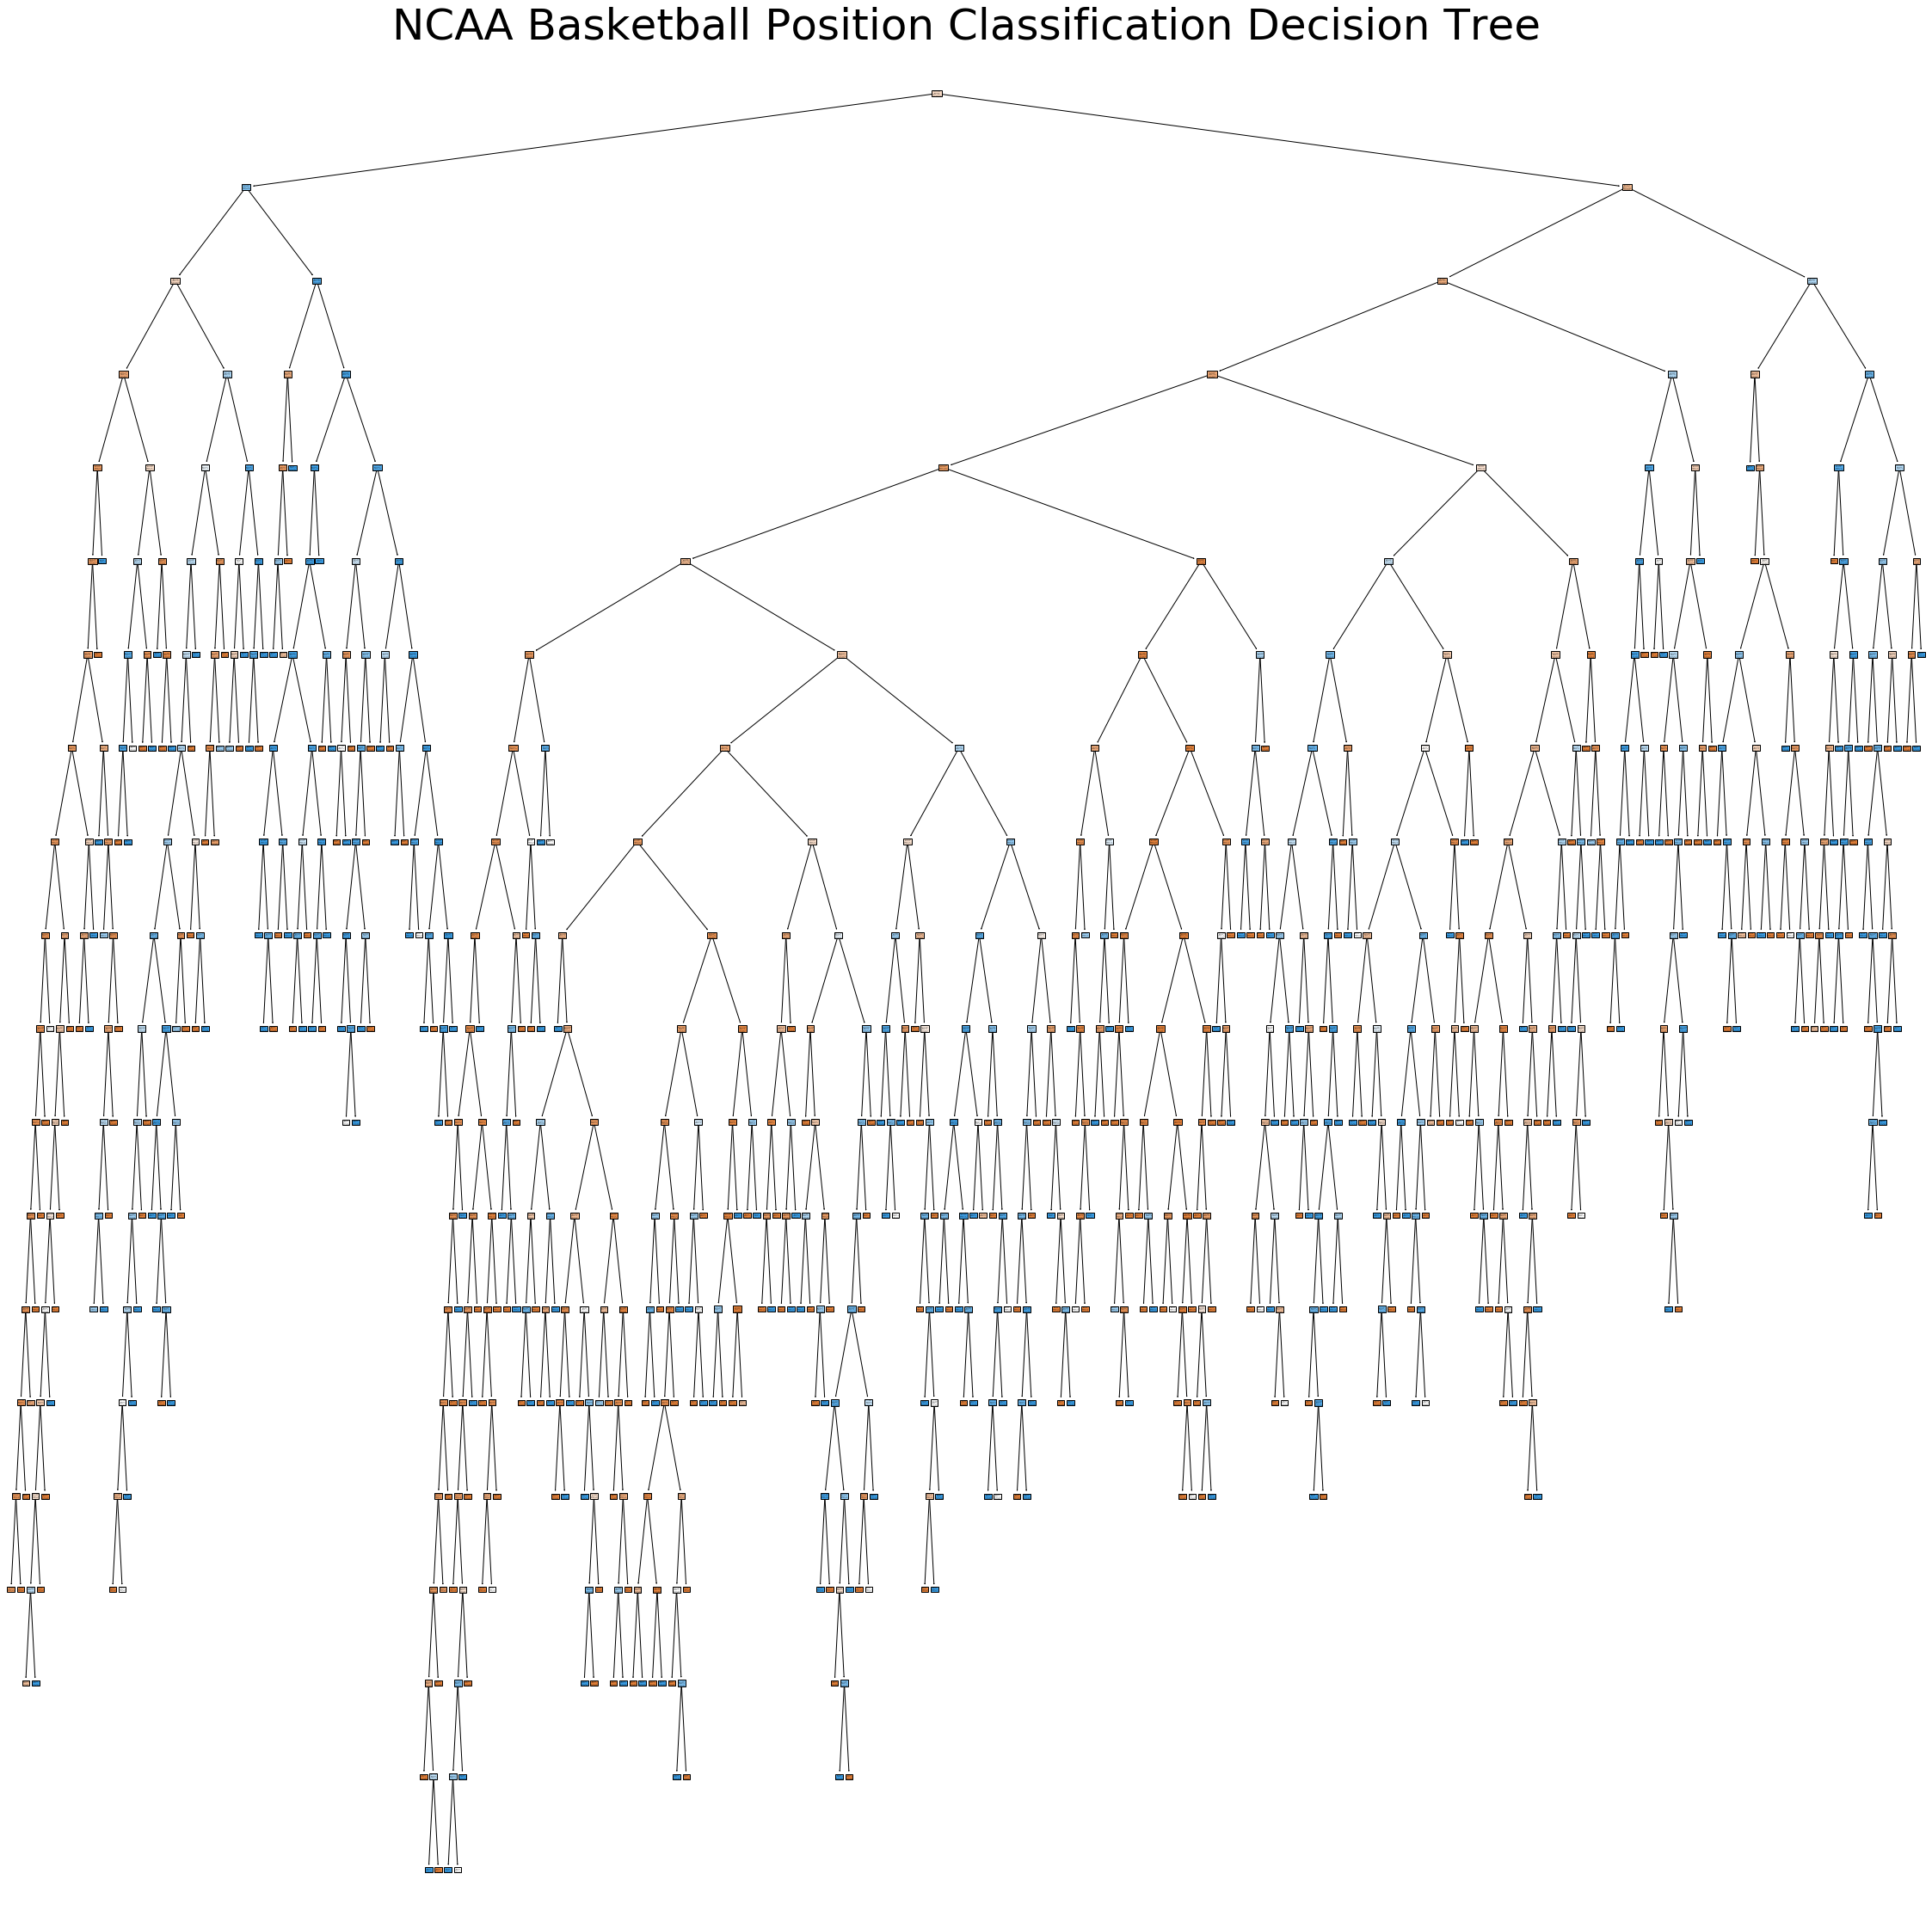

In [52]:
sample_dt = rf.estimators_[5]
fig, ax  = plt.subplots(figsize=[40,40])
plot_tree(sample_dt, feature_names=x.columns, class_names =['Guard','Forward'], filled=True, 
          ax=ax)
ax.set_title('NCAA Basketball Position Classification Decision Tree', fontsize=50)

Plot first 4 layers of a sample Decision Tree from Random Forest

Text(0.5, 1.0, 'NCAA Basketball Position Classification Decision Tree')

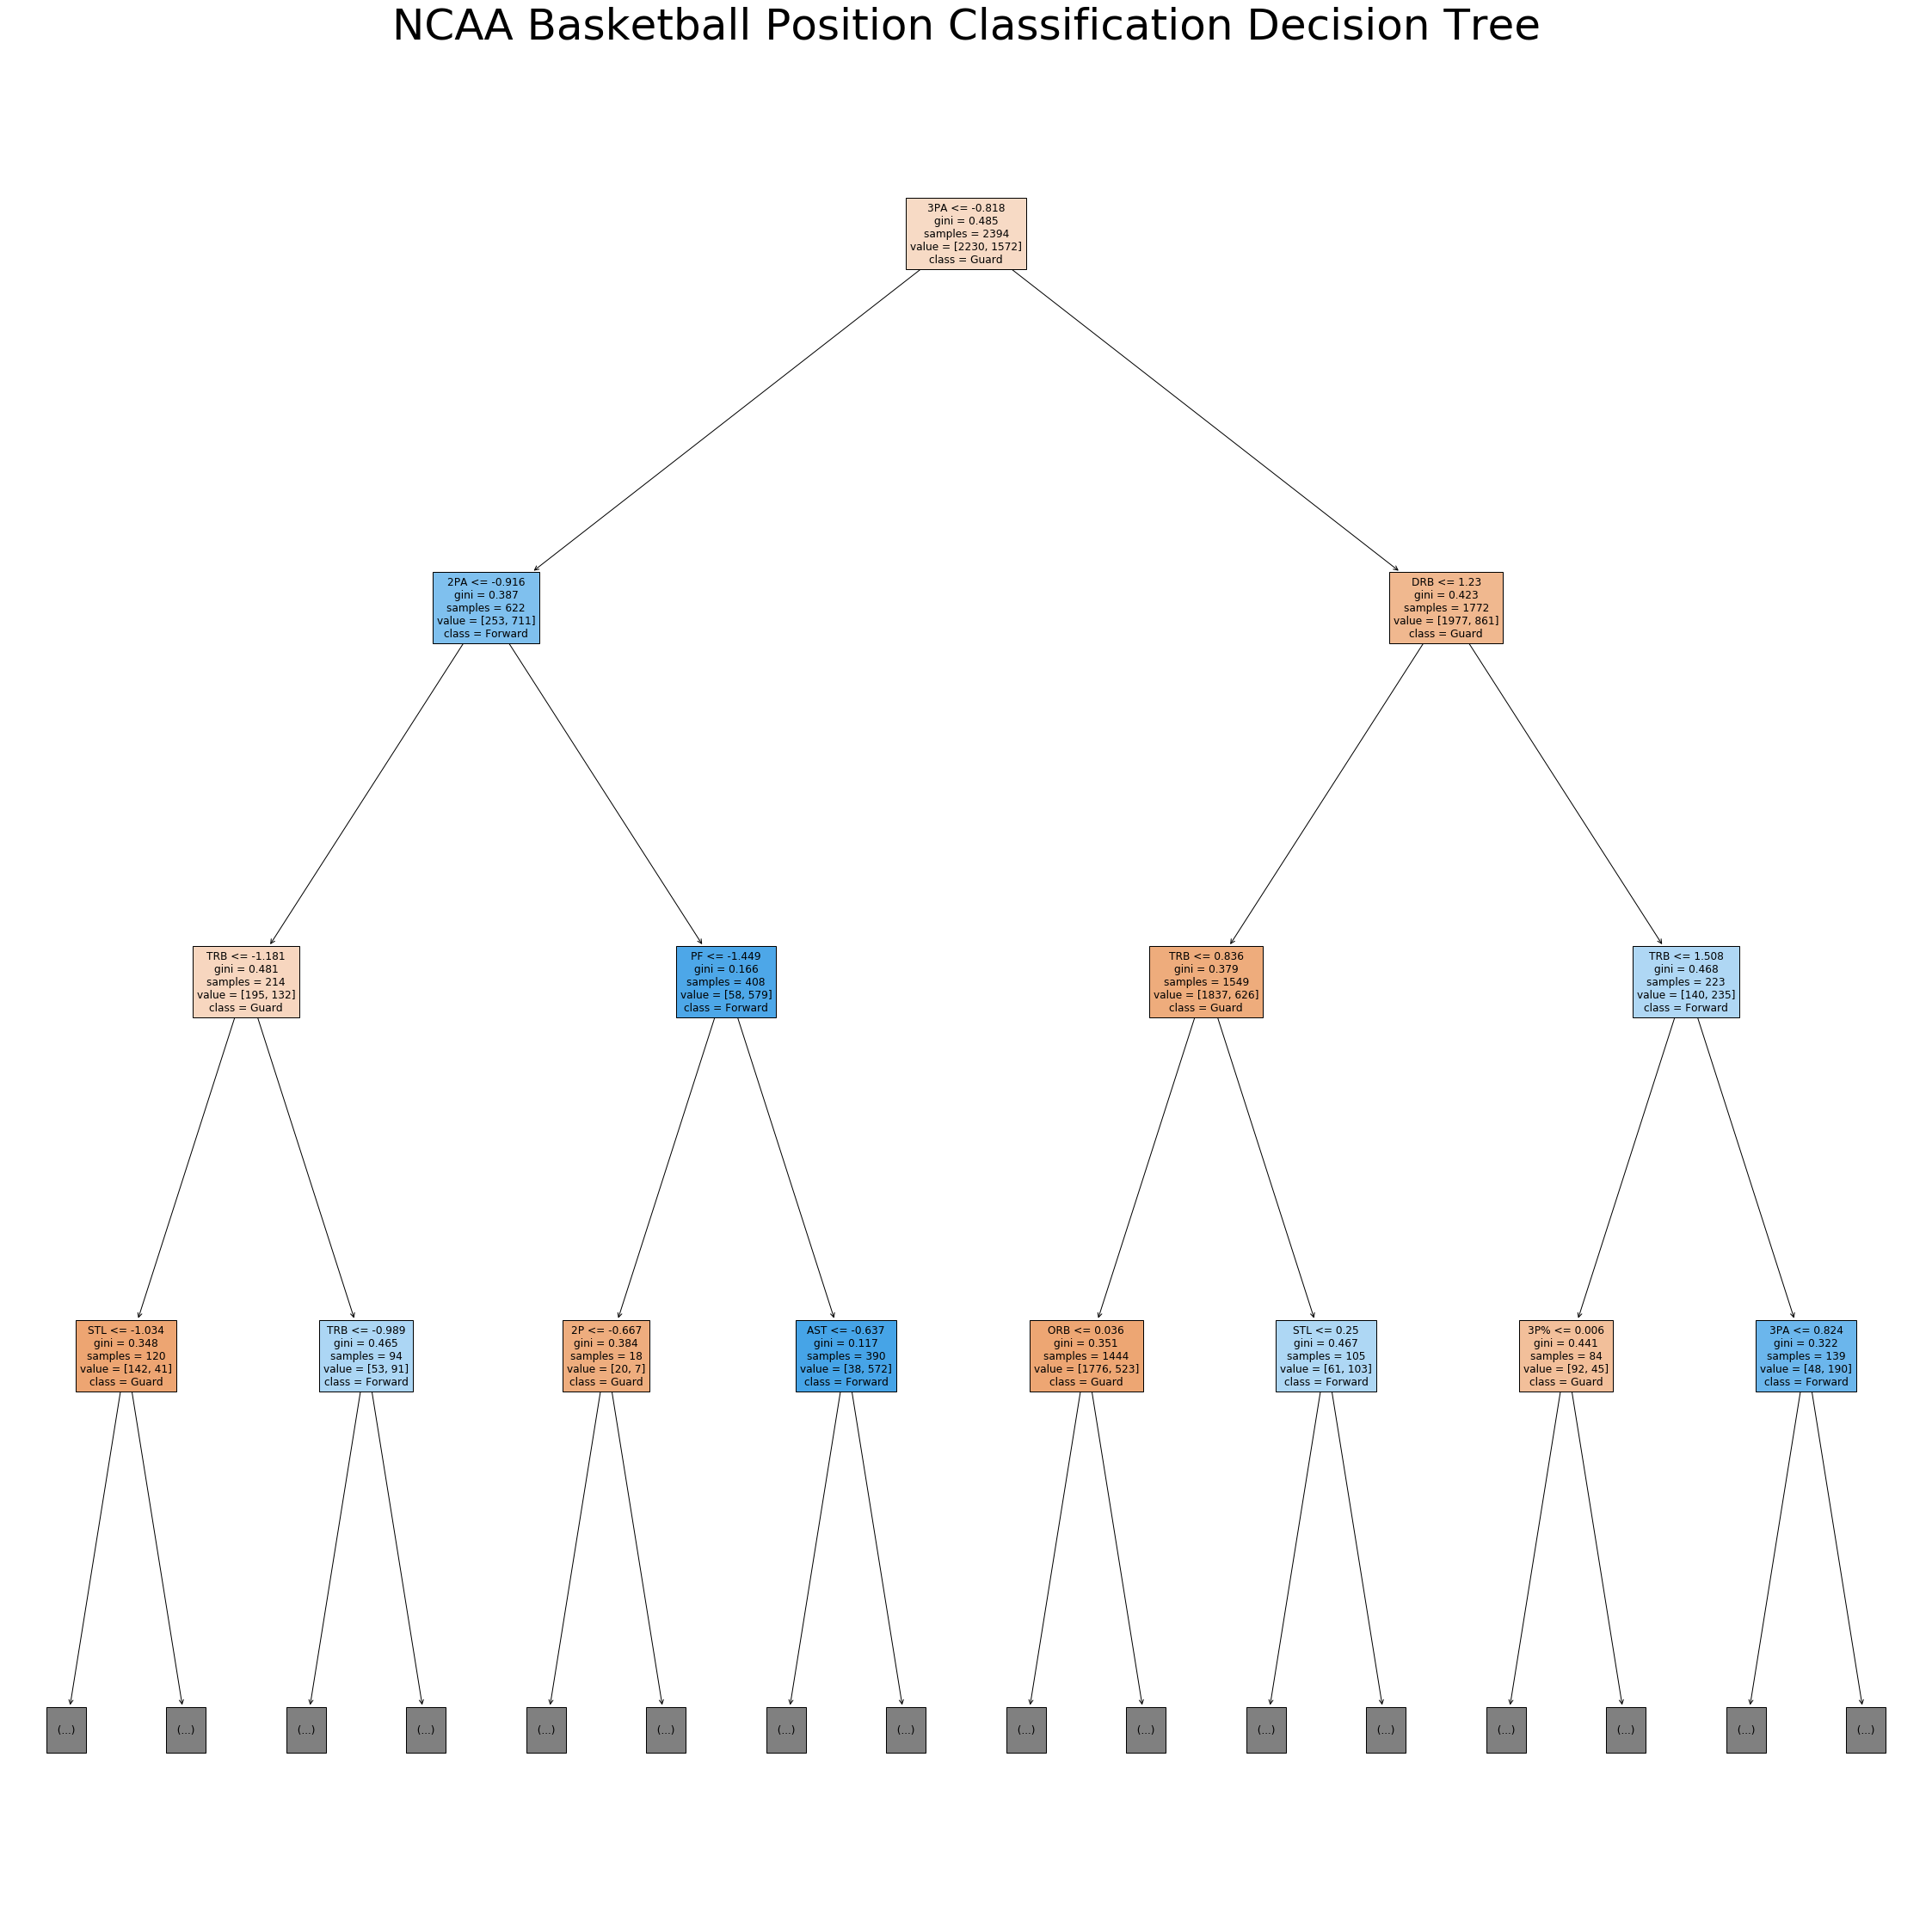

In [56]:
sample_dt = rf.estimators_[5]
fig, ax  = plt.subplots(figsize=[40,40])
plot_tree(sample_dt, feature_names=x.columns, class_names =['Guard','Forward'], filled=True, 
          ax=ax, max_depth=3)
ax.set_title('NCAA Basketball Position Classification Decision Tree', fontsize=50)

Crate df of XGBoost feature importances

In [95]:
xgb_feature_importances = pd.DataFrame(xgb.feature_importances_, columns=['Importance'])
xgb_feature_importances.index = x.columns 
xgb_feature_importances.sort_values(by='Importance', ascending=False, inplace=True)
xgb_feature_importances

,Importance
BLK,0.284992
ORB,0.168887
3PA,0.110534
AST,0.102459
STL,0.064146
FG%,0.057971
3P,0.031401
DRB,0.025309
TRB,0.020371
FGA,0.019103


Plot XGBoost feature importances

[Text(0, 0, 'BLK'),
 Text(0, 0, 'ORB'),
 Text(0, 0, '3PA'),
 Text(0, 0, 'AST'),
 Text(0, 0, 'STL'),
 Text(0, 0, 'FG%'),
 Text(0, 0, '3P'),
 Text(0, 0, 'DRB'),
 Text(0, 0, 'TRB'),
 Text(0, 0, 'FGA'),
 Text(0, 0, 'PF'),
 Text(0, 0, '2P'),
 Text(0, 0, '2PA'),
 Text(0, 0, 'TOV'),
 Text(0, 0, 'FT'),
 Text(0, 0, '2P%'),
 Text(0, 0, '3P%'),
 Text(0, 0, 'FTA'),
 Text(0, 0, 'FT%'),
 Text(0, 0, 'PTS'),
 Text(0, 0, 'FG')]

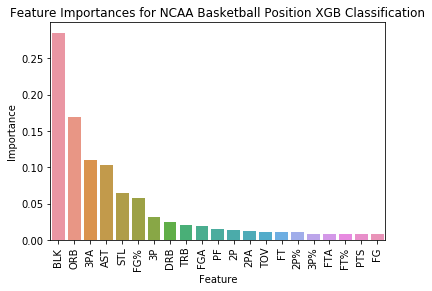

In [99]:
fig, ax = plt.subplots()
sns.barplot(x='index',y='Importance',data=xgb_feature_importances.reset_index(), ax=ax)
ax.set_title('Feature Importances for NCAA Basketball Position XGB Classification')
ax.set_xlabel('Feature')
ax.set_xticklabels(xgb_feature_importances.index, rotation=90)

Create t-SNE of x variables

In [30]:
tsne = TSNE(n_components=2, verbose=1, perplexity=45, n_iter=1500)
tsne_output = tsne.fit_transform(x)
tsne_df = pd.DataFrame(tsne_output, columns = ['d1', 'd2'])
tsne_df.head()

[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 4753 samples in 0.007s...
[t-SNE] Computed neighbors for 4753 samples in 0.440s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4753
[t-SNE] Computed conditional probabilities for sample 2000 / 4753
[t-SNE] Computed conditional probabilities for sample 3000 / 4753
[t-SNE] Computed conditional probabilities for sample 4000 / 4753
[t-SNE] Computed conditional probabilities for sample 4753 / 4753
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.348114
[t-SNE] KL divergence after 1500 iterations: 1.227089


,d1,d2
0,56.571918,-43.834595
1,59.888432,-34.076893
2,27.835108,-7.895554
3,20.518797,-11.681346
4,27.617092,-12.873783


Plot t-SNE of x variables with class

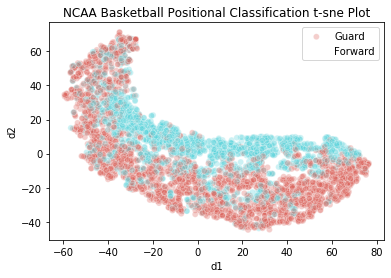

In [78]:
tsne_plot = sns.scatterplot(
    x="d1", y="d2",
    hue=y,
    palette=sns.color_palette("hls", 2),
    data=tsne_df,
    legend="full",
    alpha=0.3)
tsne_plot.set_title('NCAA Basketball Positional Classification t-sne Plot')
tsne_plot.legend(['Guard', 'Forward'])